In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

In [3]:
df  = pd.read_csv('./fraudTest.csv',index_col=0)
df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,...,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,Bellmore,...,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,Titusville,...,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,Falmouth,...,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


394.0       54
37.0        53
218.0       51
161.0       51
589.0       51
            ..
78864.0      1
284576.0     1
73062.0      1
31236.0      1
106544.0     1
Name: recency, Length: 105507, dtype: int64


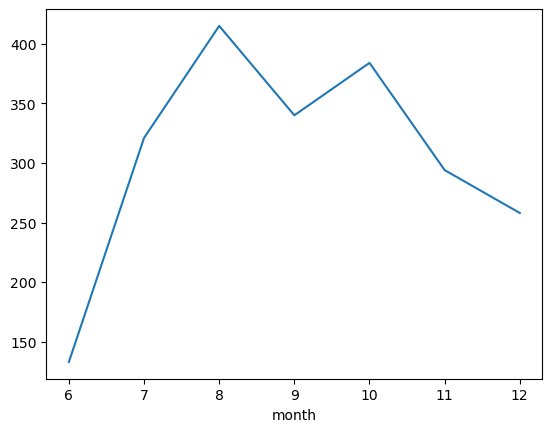

In [4]:
df = df.drop("trans_num",axis=1)
df = df.drop(['first','last'],axis=1)

## 상인과 소비자의 위도 경도 변수를 통하여 거리로 하여 새로운 변수 생성

from haversine import haversine, Unit 
df['distance']=0
for i in range(df.shape[0]):
    result = haversine((df['lat'][i],df['long'][i]) , (df['merch_lat'][i], df['merch_long'][i]), unit='mi')
    df['distance'][i]= result
df.drop(['lat','merch_lat','long','merch_long'],axis=1,inplace=True)

## 위도 차이와 경도차이를 이용하여 거리변수를 생성
## 단위 마일

## 온라인의 경우 

# trans_date_trans_time : 트랜잭션 날짜 시간, dob : 신용카드 소지자의 생년월일
# 둘의 차이를 이용해 나이 계산
date_test = pd.to_datetime(df['trans_date_trans_time'], format='%Y-%m-%d').dt.strftime('%Y').astype(int)
date_test2 = pd.to_datetime(df['dob'], format='%Y-%m-%d').dt.strftime('%Y').astype(int)
df['age'] = date_test - date_test2
## dob 변수 제거
df.drop('dob',axis=1,inplace=True)

### 같은 카드에서 다음 거래까지 걸린 시간의 차이를 단위(초)로 하여 나타냄
## unix 타임기준으로 발생기록되어있음
df["recency"] = df.groupby(by="cc_num")["unix_time"].diff()
print(df['recency'].value_counts())
df['recency'].fillna(0,inplace=True)  # 첫 거래에 있는 na값은 0으로 처리
df.drop("unix_time",1,inplace=True)

# street , city, city_pop,state, zip 변수는 지역을 나타내는 변수로 이 지역의 규모를 범주화하여 변수를 만듬
# 대도시는 인구 50만명 이상, 중소도시는 10만명 이상에서 50만명 이하, 소도시는 10만명 이하로 구분하고 있다.
# 변수의 단위가 10으로 되어있음
df.loc[(df["city_pop"]<10000),["city_pop_category"]] = "소도시"
df.loc[((df["city_pop"]>10000) & (df["city_pop"]<50000)),["city_pop_category"]] = "중소도시"
df.loc[(df["city_pop"]>50000),["city_pop_category"]] = "대도시"

df.drop(['city','city_pop','street','zip'],axis=1,inplace=True)
## 소도시에서 이상거래가 발생되는 것을 확인 할 수 있다
df['city_pop_category'][df['is_fraud']==1].value_counts()

## trans_date_trans_time 변수는 이 데이터 셋 자체가 과거의 데이터기 때문에 중요한 변수는 아닐것이라 생각한다
## 그러나 월별 ,시간 대 는 중요한 요소가 될수 있을것 같다.

## 거래 시간을 새 파생변수 'trans_hour'로 만든 후 시간 별 이상거래 확인 
df['trans_hour'] = pd.to_datetime(df['trans_date_trans_time']).dt.strftime('%H').astype(int)




#새 파생변수 'trans_hour_category' 생성
df.loc[(df['trans_hour']>=7) & (df['trans_hour']<=20),'trans_hour_category'] = 'day'
df.loc[(df['trans_hour']>=21) | (df['trans_hour']<=6),'trans_hour_category'] = 'night'

# 새로운 파생변수 month / trans_date_trans_time 시계열로 변경 후 월만 int형으로 출력
df['month'] = pd.to_datetime(df['trans_date_trans_time']).dt.strftime('%m').astype(int)

# 그래프 그리기
df[df['is_fraud']==1].groupby('month')['is_fraud'].count().plot()
plt.show()
# 데이터프래임으로 확인
df[df['is_fraud']==1].groupby('month')[['is_fraud']].count()

# 데이터 변경 함수
def change(x):
    if x < 7:
        result = '상반기'
    else:
        result = '하반기'
    return result

# 새로운 파생변수 half_month 1~6월 :상반기 7~12월 : 하반기
df['trans_month_category'] = df['month'].apply(change)

## state 변수 지역별로 범주화 
## region 변수 생성
from tqdm import tqdm

west = ['WA', 'MT', 'ID', 'OR', 'WY', 'NV', 'UT', 'CO', 'NM', 'AZ', 'CA', 'HI', 'AK']
mid_west = ['ND', 'SD', 'NE', 'KS', 'MN', 'IA', 'MO', 'WI', 'IL', 'MI', 'IN', 'OH']
south = ['TX', 'OK', 'AR', 'LA', 'MS', 'AL', 'GA', 'FL', 'TN', 'KY', 'WV', 'VA', 'NC', 'SC', 'DE', 'MD', 'DC']
north_east = ['VT', 'ME', 'VT', 'NY', 'PA', 'CT', 'NJ', 'RI', 'MA']

def change(x):
    if x in west:
        result = 'west'
    elif x in mid_west:
        result = 'mid_west'
    elif x in south:
        result = 'south'
    else:
        result = 'north_east'
    return result

df['region'] = df['state'].apply(change)

df.drop('state',axis=1,inplace=True)
df.drop('merchant',axis=1,inplace=True)
df.drop('cc_num',axis=1,inplace=True)

df.drop('job',axis=1,inplace=True)

In [7]:
df.drop('trans_date_trans_time',axis=1,inplace=True)

In [8]:
df.head()

,category,amt,gender,is_fraud,distance,age,recency,city_pop_category,trans_hour,trans_hour_category,month,trans_month_category,region
0,personal_care,2.86,M,0,15.261806,52,0.0,대도시,12,day,6,상반기,south
1,personal_care,29.84,F,0,65.197520,30,0.0,소도시,12,day,6,상반기,west
2,health_fitness,41.28,F,0,36.710709,50,0.0,중소도시,12,day,6,상반기,north_east
3,misc_pos,60.05,M,0,17.211116,33,0.0,대도시,12,day,6,상반기,south
4,travel,3.19,M,0,64.830919,65,0.0,소도시,12,day,6,상반기,mid_west


In [9]:
col = ['region','trans_month_category','trans_hour_category','city_pop_category','gender','category']
df_dummy = pd.get_dummies(df[col])
df.drop(col,axis=1,inplace=True, errors='ignore')
df = pd.concat([df,df_dummy],axis=1)
mapping = {'trans_category_기타': '기타거래','trans_category_온라인거래':'온라인거래','trans_category_오프라인거래':'오프라인거래','trans_month_category_상반기':'상반기','trans_month_category_하반기':'하반기','trans_hour_category_day':'주간','trans_hour_category_night':'야간','city_pop_category_대도시':'대도시','city_pop_category_중소도시':'중소도시','city_pop_category_소도시':'소도시','gender_F':'남성','gender_M':'여성','amt':'거래량','distance':'카드거래발생거리','age':'실소유자나이','recency':'카드거래간시간','region_mid_west':'중서부','region_north_east':'북동부','region_south':'남부','region_west':'서부','is_fraud':'이상거래'}
df.rename(columns = mapping,inplace=True) 

In [12]:
df.drop(['trans_hour', 'month'],axis=1,inplace=True)

In [13]:
df.head()

,거래량,이상거래,카드거래발생거리,실소유자나이,카드거래간시간,중서부,북동부,남부,서부,상반기,...,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel
0,2.86,0,15.261806,52,0.0,0,0,1,0,1,...,0,0,0,0,0,0,1,0,0,0
1,29.84,0,65.197520,30,0.0,0,0,0,1,1,...,0,0,0,0,0,0,1,0,0,0
2,41.28,0,36.710709,50,0.0,0,1,0,0,1,...,0,1,0,0,0,0,0,0,0,0
3,60.05,0,17.211116,33,0.0,0,0,1,0,1,...,0,0,0,0,0,1,0,0,0,0
4,3.19,0,64.830919,65,0.0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [14]:
df.to_csv('yet_test.csv',encoding='UTF-8-sig')